In [2]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from src.time_series_functions import *
# from pandas.plotting import register_matplotlib_converters
# register_matplotlib_converters()

# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
keras = tf.keras
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
# from keras.callbacks import EarlyStopping#, ModelCheckpoint
from keras.metrics import MeanAbsolutePercentageError


%matplotlib inline

In [3]:
base_df = csv_with_datetime('data/master_df.csv', 'ds')
df = base_df.copy()
df.drop('Unnamed: 0', axis=1, inplace=True)
df.info(), df.head(3)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11323 entries, 1990-01-01 to 2020-12-31
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   ds            11323 non-null  datetime64[ns]
 1   y             11323 non-null  float64       
 2   avg_temp      11323 non-null  float64       
 3   precip_accum  11323 non-null  float64       
 4   swe           11323 non-null  float64       
 5   hist_avg_y    11323 non-null  float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 619.2 KB


(None,
                    ds    y  avg_temp  precip_accum  swe  hist_avg_y
 ds                                                                 
 1990-01-01 1990-01-01  6.5      19.0           5.6  4.8    6.437742
 1990-01-02 1990-01-02  6.9      16.0           5.7  4.8    6.502258
 1990-01-03 1990-01-03  6.9       2.0           5.7  4.8    6.673226)

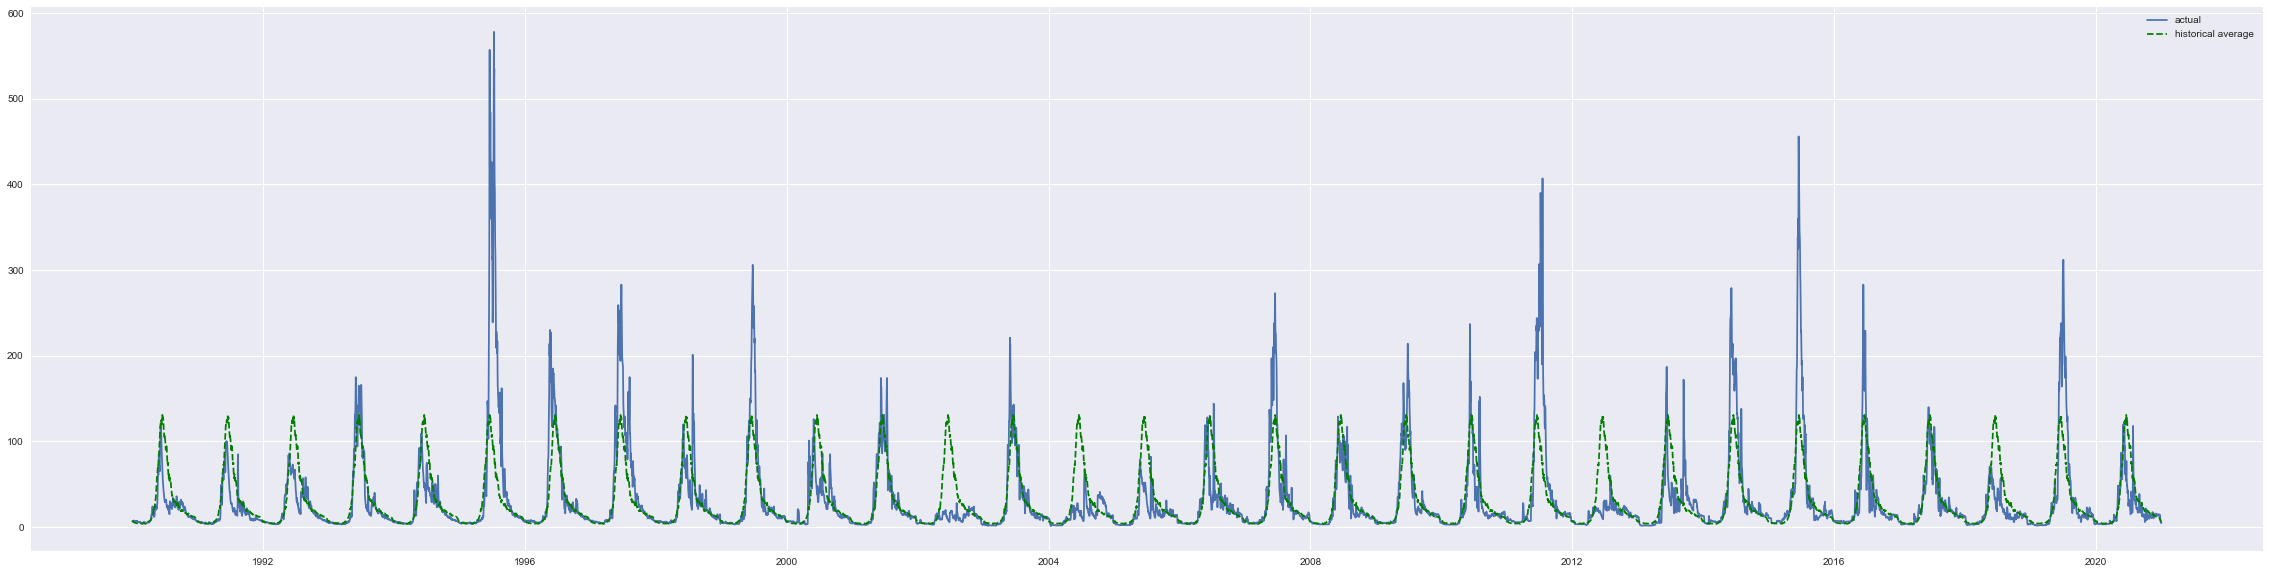

In [4]:
plt.figure(figsize=(40,10))
plt.plot(df.index,df['y'],label='actual');
plt.plot(df.index,df['hist_avg_y'],label='historical average', color='green', linestyle='dashed')
plt.legend();

In [5]:
sub_df = df['2016':'2020']

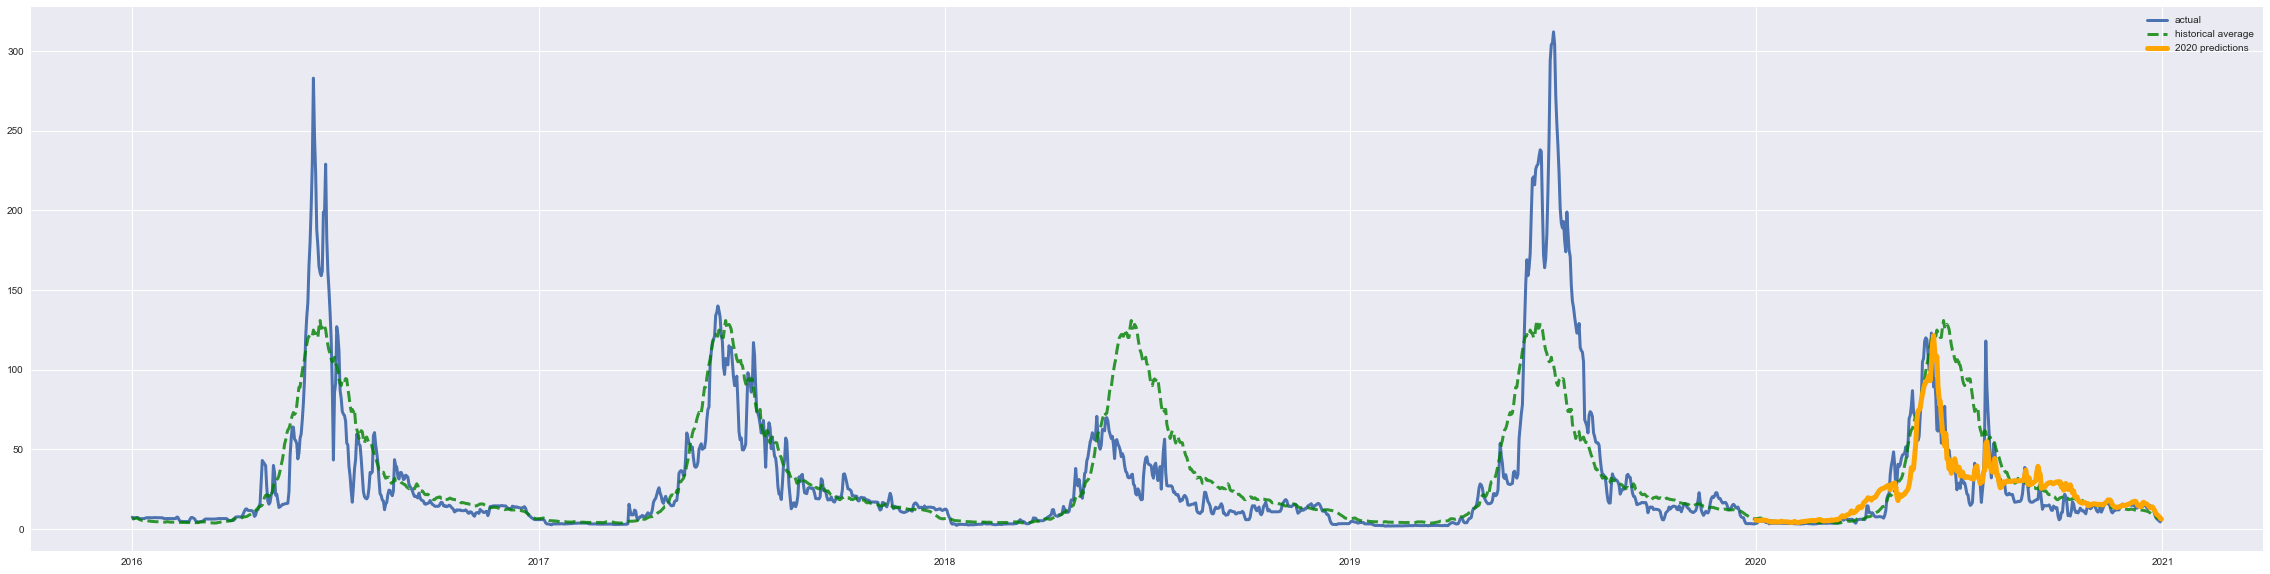

In [55]:
plt.figure(figsize=(40,10))
plt.plot(sub_df.index,sub_df['y'],label='actual', linewidth=3);
plt.plot(sub_df.index,sub_df['hist_avg_y'],label='historical average', linewidth=3, color='green', alpha=0.8, linestyle='dashed')
plt.plot(sub_df['2020'].index, y_pred_2020, label='2020 predictions', linewidth=5, color='orange')
plt.legend();

In [26]:
lstm_v12 = keras.models.load_model('models/LSTM_v12.h5')

In [ ]:
# #for each year: 
# take 6000 record sample that ends with desired year
# convert datetime column to continuous integer
# scale entire dataframe except y column (don't pass in historical y)
# use windowize function to create X_test that represents year predicting
# pass X_test to model and predict, return results and plot (final day from each return row)

In [14]:
pred_year = '2020'

In [15]:
# take 6000 record sample that ends with desired year

#making desired year last year in sample data
samp_df = df[:pred_year].copy()

#trimming sample data to 6000 records total
samp_df = df.iloc[-6000:].copy()

# convert datetime column to continuous integer
samp_df['ds'] = pd.to_datetime(df['ds']).sub(pd.Timestamp(df['ds'].iloc[0])).dt.days

In [17]:
#don't pass in historical y to model
samp_df.drop('hist_avg_y', axis=1, inplace=True)

In [18]:
# scale entire dataframe except y column 
scale_df = samp_df.copy()
for column in scale_df.columns:
  if column != 'y':
    scaler = StandardScaler()
    # print (scale_df[column].values.shape)
    holder = scaler.fit_transform(scale_df[column].values.reshape(-1,1))
    scale_df[column] = holder.reshape(len(scale_df),)

In [21]:
scale_df.info(), scale_df.head(3), scale_df.tail(3)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6000 entries, 2004-07-29 to 2020-12-31
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ds            6000 non-null   float64
 1   y             6000 non-null   float64
 2   avg_temp      6000 non-null   float64
 3   precip_accum  6000 non-null   float64
 4   swe           6000 non-null   float64
dtypes: float64(5)
memory usage: 281.2 KB


(None,
                   ds     y  avg_temp  precip_accum       swe
 ds                                                          
 2004-07-29 -1.731762  33.0  1.050907      0.487837 -0.931964
 2004-07-30 -1.731185  28.0  0.914353      0.508494 -0.931964
 2004-07-31 -1.730607  26.0  1.392292      0.508494 -0.931964,
                   ds     y  avg_temp  precip_accum       swe
 ds                                                          
 2020-12-29  1.730607  4.99 -1.680170     -1.061463 -0.127640
 2020-12-30  1.731185  4.48 -1.885000     -1.061463 -0.127640
 2020-12-31  1.731762  5.62 -1.202231     -1.051135 -0.112464)

In [ ]:
# defining the size of test data (how many days do we want to predict?)
# can functionize this later with 'is leap year' function
test_size = 365
# test_size = 366

In [22]:
X, y = windowize_data(scale_df, n_prev, 'y', predict_steps)
X_test = X[-test_size:]
y_test = y[-test_size:]
X_test.shape, y_test.shape

((366, 400, 5), (366, 1))

In [23]:
#these variables can't be changed without retraining model
n_prev = 400 #model was trained on this input shape
predict_steps = 30 #model was trained on this output shape

In [35]:
y_pred = lstm_v12.predict(X_test)

In [36]:
# y_pred_complete = y_pred

In [65]:
y_pred[y_pred<0] = 0

In [47]:
y_pred_2020 = y_pred[:,:1]

In [56]:
y_pred_2020_tail = y_pred[:,-1:]

In [58]:
y_pred_2020_2wk = y_pred[:,13:14]

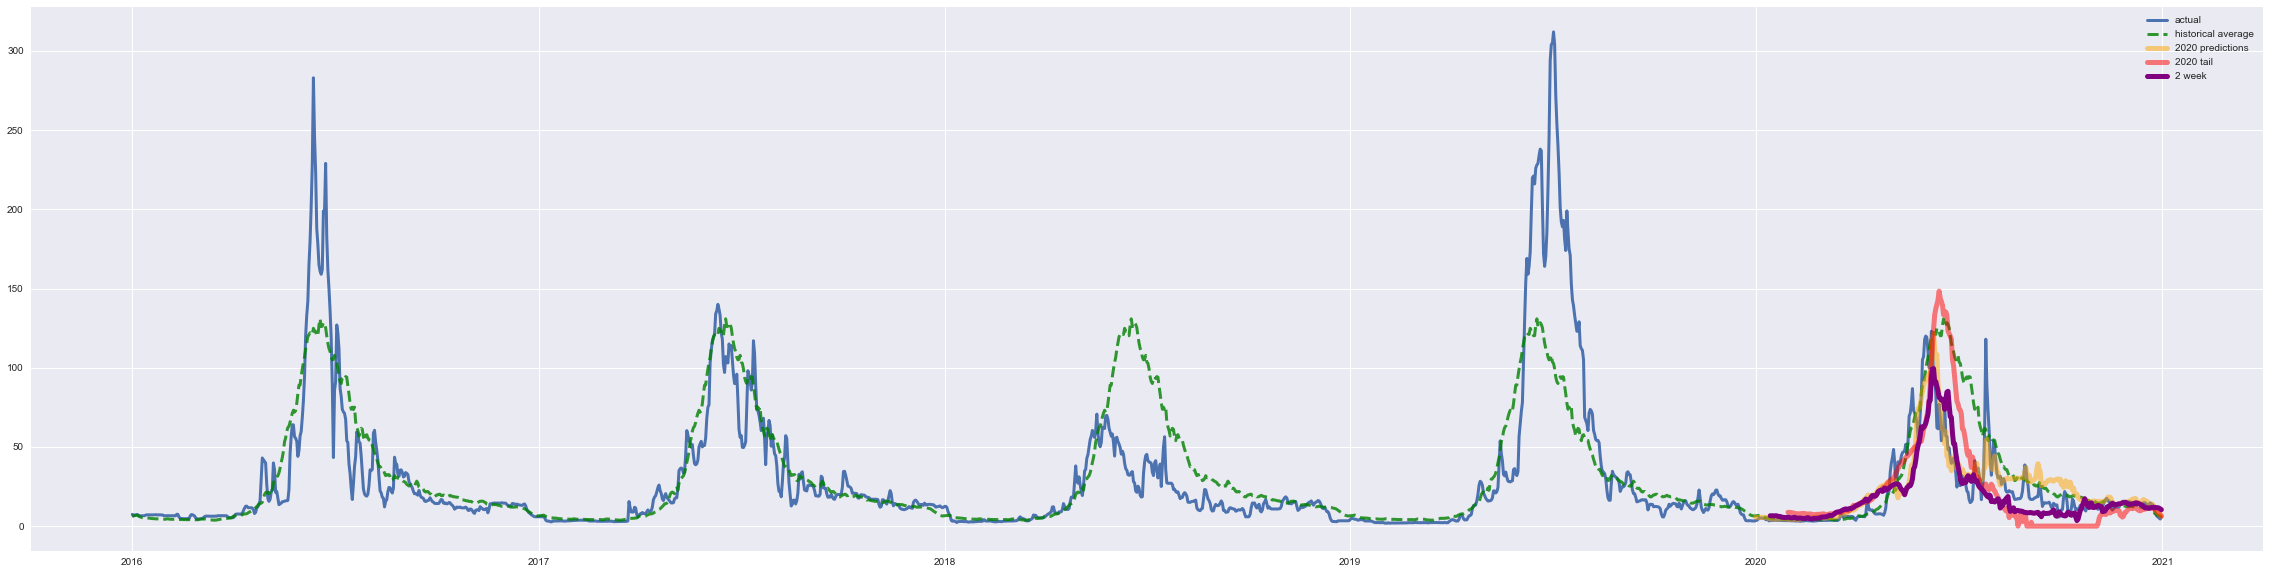

In [77]:
plt.figure(figsize=(40,10))
plt.plot(sub_df.index,sub_df['y'],label='actual', linewidth=3);
plt.plot(sub_df.index,sub_df['hist_avg_y'],label='historical average', linewidth=3, color='green', alpha=0.8, linestyle='dashed')
plt.plot(sub_df['2020'].index, y_pred_2020, label='2020 predictions', linewidth=5, color='orange', alpha=0.5)
plt.plot(sub_df['2020-01-30':].index, y_pred_2020_tail[:-29], label='2020 tail', linewidth=5, color='red', alpha=0.5)
plt.plot(sub_df['2020-01-14':].index, y_pred_2020_2wk[:-13], label='2 week', linewidth=5, color='purple')


plt.legend();

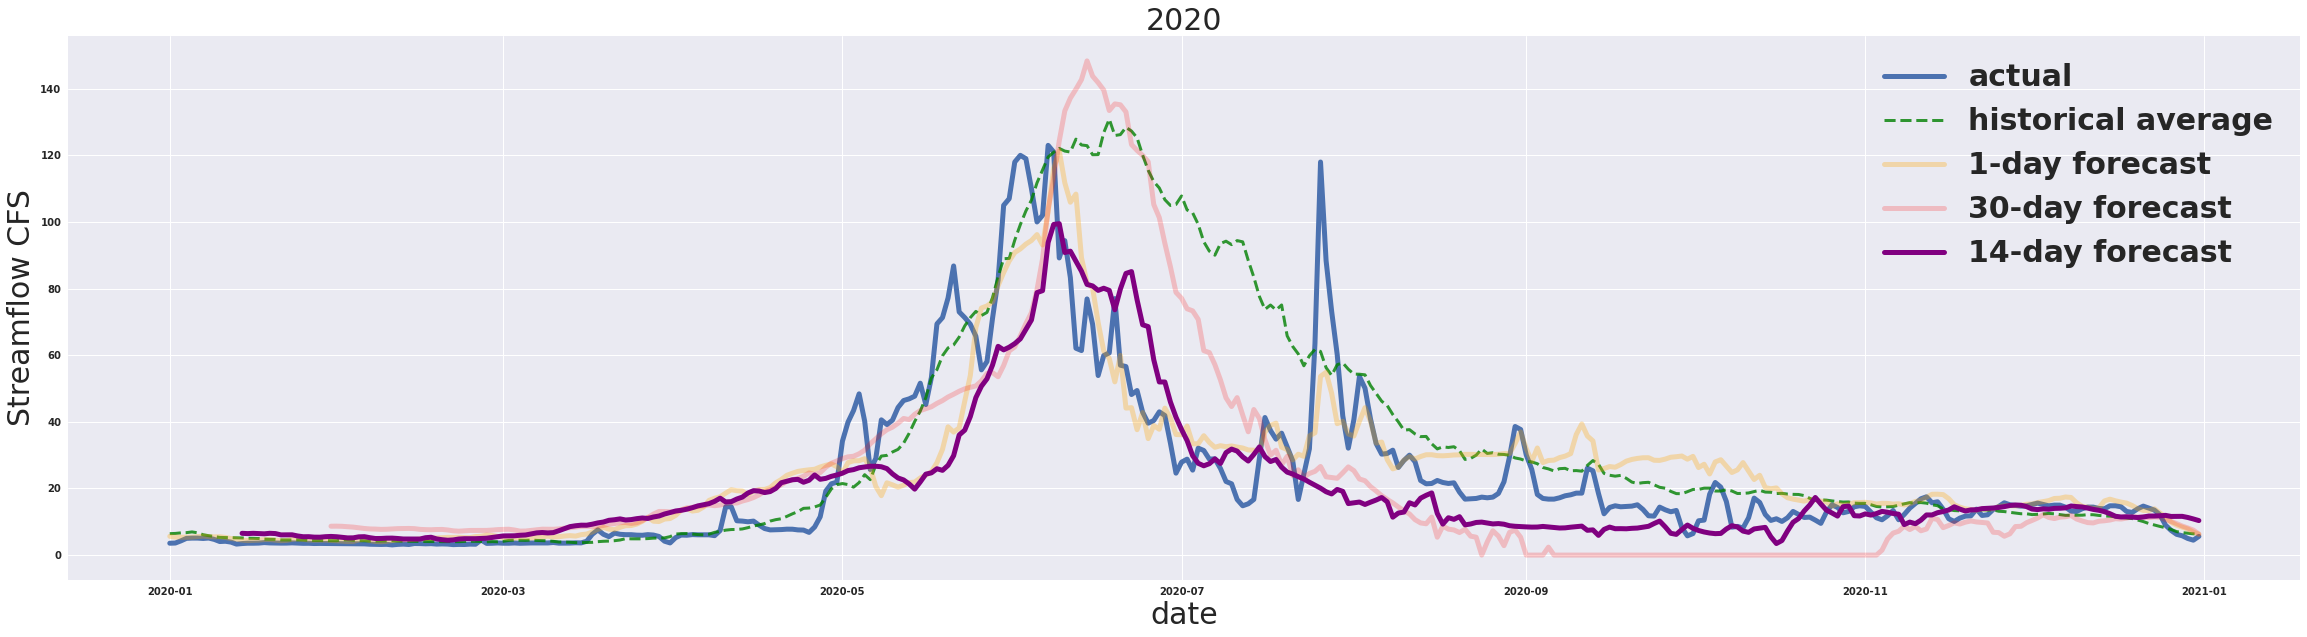

In [128]:
fig, ax = plt.subplots(figsize=(40,10))
plt.rcParams['font.size'] = '16'
# plt.figure(figsize=(40,10))
ax.plot(sub_df[pred_year].index,sub_df[pred_year]['y'],label='actual', linewidth=5);
ax.plot(sub_df[pred_year].index,sub_df[pred_year]['hist_avg_y'],label='historical average', linewidth=3, color='green', alpha=0.8, linestyle='dashed')
ax.plot(sub_df['2020'].index, y_pred_2020, label='1-day forecast', linewidth=5, color='orange', alpha=0.3)
# ax.plot(sub_df['2020-01-30':].index, y_pred_2020_tail[:-29], label='30-day forecast', linewidth=5, color='red', alpha=0.2)
ax.plot(sub_df['2020'].index[29:], y_pred_2020_tail[:-29], label='30-day forecast', linewidth=5, color='red', alpha=0.2)
ax.plot(sub_df['2020-01-14':].index, y_pred_2020_2wk[:-13], label='14-day forecast', linewidth=5, color='purple')
ax.set_title('2020', fontsize=30)
ax.set_xlabel('date',fontsize=30)
ax.set_ylabel('Streamflow CFS', fontsize=30)
plt.legend(prop={"size":30});

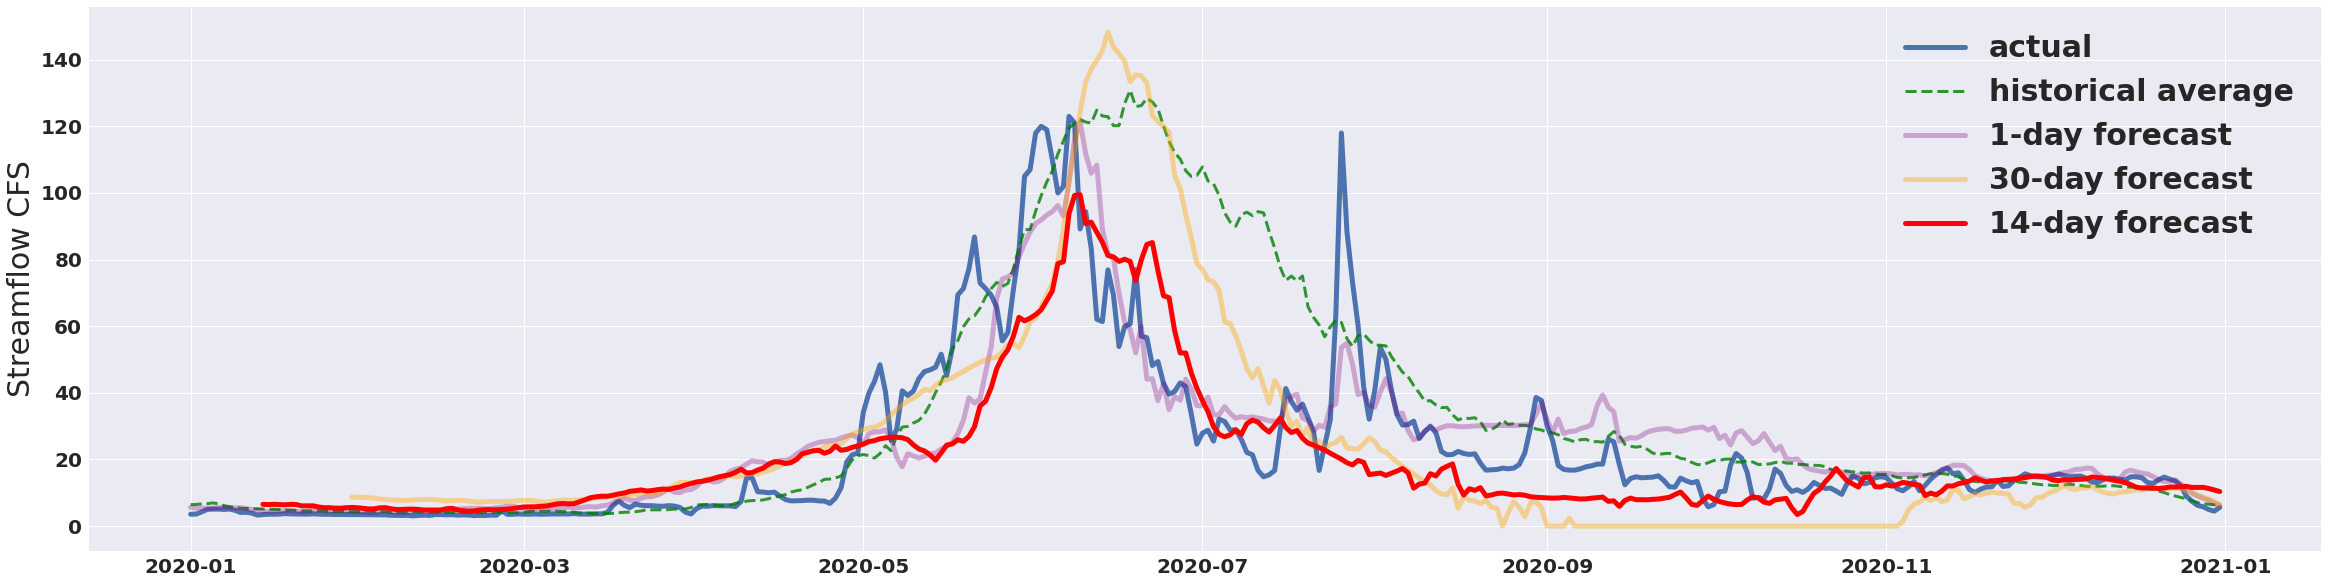

In [125]:

plt.figure(figsize=(40,10))
plt.plot(sub_df[pred_year].index,sub_df[pred_year]['y'],label='actual', linewidth=5);
plt.plot(sub_df[pred_year].index,sub_df[pred_year]['hist_avg_y'],label='historical average', linewidth=3, color='green', alpha=0.8, linestyle='dashed')
plt.plot(sub_df['2020'].index, y_pred_2020, label='1-day forecast', linewidth=5, color='purple', alpha=0.3)
plt.plot(sub_df['2020-01-30':].index, y_pred_2020_tail[:-29], label='30-day forecast', linewidth=5, color='orange', alpha=0.4)
plt.plot(sub_df['2020-01-14':].index, y_pred_2020_2wk[:-13], label='14-day forecast', linewidth=5, color='red')

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Streamflow CFS', fontsize=30)
plt.legend(prop={"size":30});

In [118]:
mape = tf.keras.metrics.MeanAbsolutePercentageError()
mape.update_state(y_test, y_pred[:,13:14])
mape.result().numpy()

61.39258

In [117]:
#two-week predictions rmse
sqrt(mean_squared_error(y_test, y_pred[:,13:14]))

14.689006482128477

In [119]:
#baseline rmse (using historical average method)
sqrt(mean_squared_error(y_test, sub_df[pred_year]['hist_avg_y']))

23.160771071415937

In [121]:
lift_over_historical = 14.689/23.160
1- lift_over_historical

0.3657599309153713

In [122]:
#37% lift over historical model

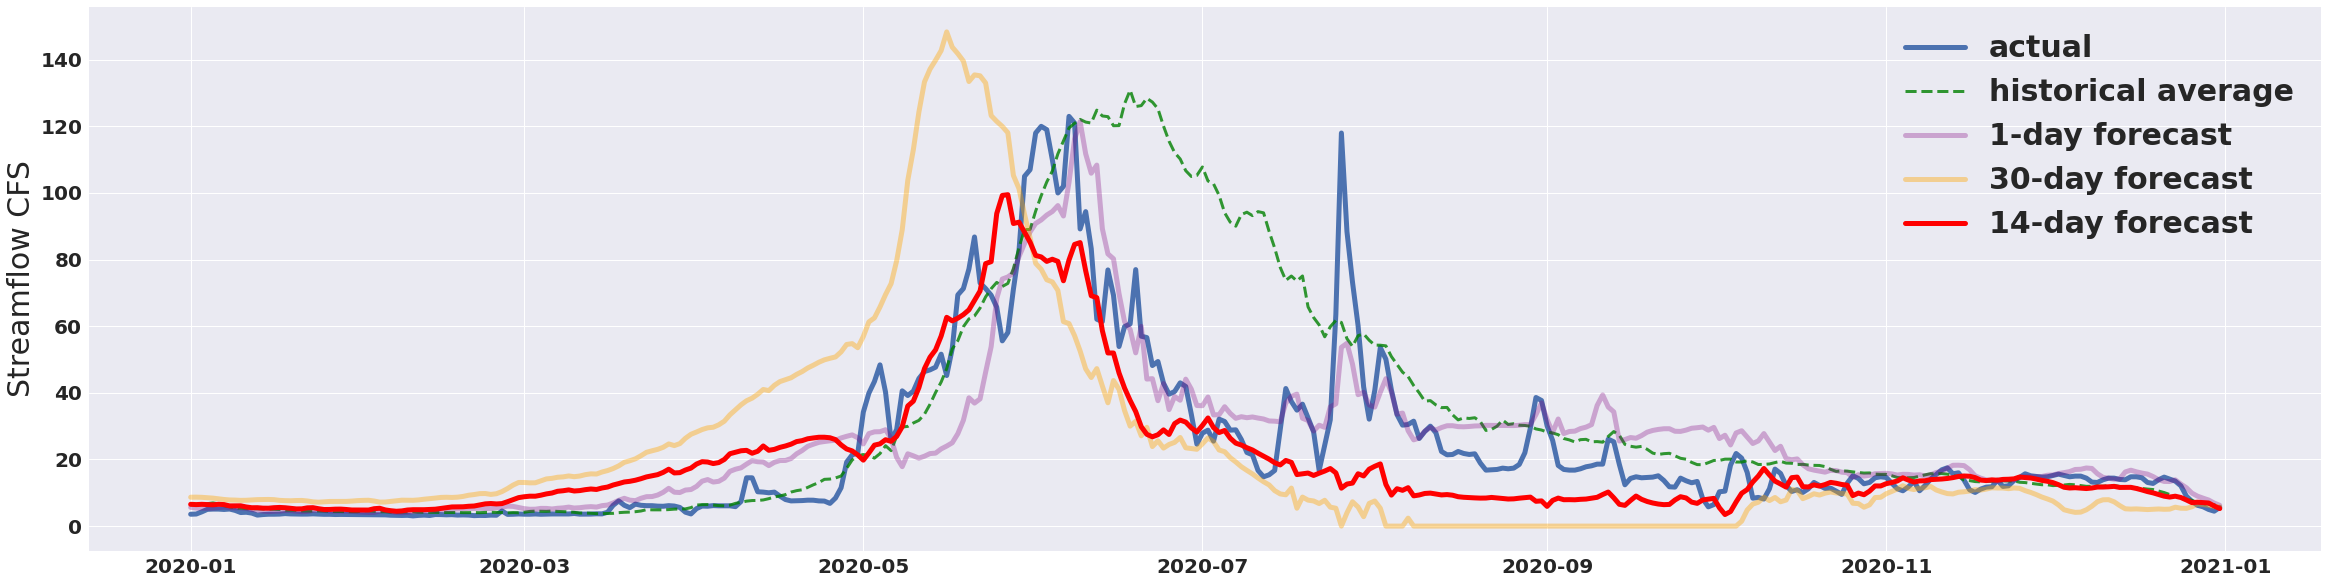

In [124]:
plt.figure(figsize=(40,10))
plt.plot(sub_df[pred_year].index,sub_df[pred_year]['y'],label='actual', linewidth=5);
plt.plot(sub_df[pred_year].index,sub_df[pred_year]['hist_avg_y'],label='historical average', linewidth=3, color='green', alpha=0.8, linestyle='dashed')
plt.plot(sub_df['2020'].index, y_pred_2020, label='1-day forecast', linewidth=5, color='purple', alpha=0.3)
plt.plot(sub_df['2020'].index, y_pred_2020_tail, label='30-day forecast', linewidth=5, color='orange', alpha=0.4)
plt.plot(sub_df['2020'].index, y_pred_2020_2wk, label='14-day forecast', linewidth=5, color='red')

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Streamflow CFS', fontsize=30)
plt.legend(prop={"size":30});